In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from datetime import date
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

In [44]:
def convert_raw_data(dataframe):
    dataframe['Date'] = pd.to_datetime(dataframe['Date'])
    dataframe['Open'] = dataframe['Open'].replace({',': ''}, regex=True).apply(pd.to_numeric)
    dataframe['Price'] = dataframe['Price'].replace({',': ''}, regex=True).apply(pd.to_numeric)
    dataframe['High'] = dataframe['High'].replace({',': ''}, regex=True).apply(pd.to_numeric)
    dataframe['Low'] = dataframe['Low'].replace({',': ''}, regex=True).apply(pd.to_numeric)
    dataframe = dataframe.sort_values(by='Date', ascending=True).reset_index(drop=True)
    return dataframe

In [45]:

def create_weekdays_december_january_dataframe():
    start_date = datetime(2023, 12, 16)
    end_date = datetime(2024, 1, 31)
    date_range = pd.date_range(start_date, end_date)
    df = pd.DataFrame({"Date": date_range})
    df = df[(df["Date"].dt.dayofweek != 5) & (df["Date"].dt.dayofweek != 6)]
    new_df = pd.DataFrame({"Date": df["Date"].dt.strftime('%Y-%m-%d')})
    new_df = new_df.head(30)
    return new_df

In [46]:
data = pd.read_csv('HNX.csv')
data = convert_raw_data(data)
data = data.dropna() # Drop missing values
data = data.reset_index(drop=True) # Reset the index

data

,Date,Price,Open,High,Low,Vol.,Change %
0,2010-01-04,179.84,168.58,179.84,168.47,26.86K,6.94%
1,2010-01-05,183.26,181.29,187.57,180.97,37.28K,1.90%
2,2010-01-06,179.56,184.78,185.50,179.48,41.57K,-2.02%
3,2010-01-07,177.95,180.82,183.24,177.89,36.69K,-0.90%
4,2010-01-08,179.76,179.76,186.01,175.59,43.84K,1.02%
...,...,...,...,...,...,...,...
3479,2023-12-11,231.37,229.93,232.59,229.86,76.36K,0.07%
3480,2023-12-12,231.71,230.03,232.91,229.90,74.25K,0.15%
3481,2023-12-13,228.42,230.19,232.57,228.09,97.24K,-1.42%
3482,2023-12-14,227.23,228.52,230.05,226.53,80.91K,-0.52%


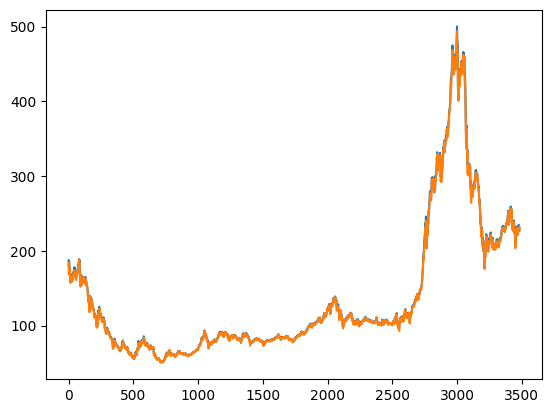

In [47]:
# gán biến
y = data[['Open']] # chuỗi thời gian cần dự báo (biến phụ thuộc)
X = data[['High']] # các biến độc lập



plt.plot(X)
plt.plot(y)
plt.show()

In [48]:
# chia train, test
# ratio = 0.7
# ratio = 0.8
ratio = 0.9

train_size = int(ratio * len(data))
test_size = int((1-ratio) * len(data))


train_data = data[:train_size]
test_data = data[train_size:]

y_train = y[:train_size]
X_train = X[:train_size]
y_test = y[train_size:]
X_test = X[train_size:]

In [49]:

svr_modal = SVR(kernel='rbf')
svr_modal.fit(X_train, y_train)



SVR()

In [50]:
# dự đoán giá đóng cửa của HNX trên tập kiểm tra

y_pred_sigmoid = svr_modal.predict(X_test)
y_pred_sigmoid= y_pred_sigmoid.reshape(-1,1)

In [51]:

mae = mean_absolute_error(y_test, y_pred_sigmoid)
mse = mean_squared_error(y_test, y_pred_sigmoid)
mape = mean_absolute_percentage_error(y_test, y_pred_sigmoid)
rmse = np.sqrt(mse)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

MAE: 1.4373691679864076
MSE: 3.1830981266791554
RMSE: 1.784123910124842
MAPE: 0.006407171497782255


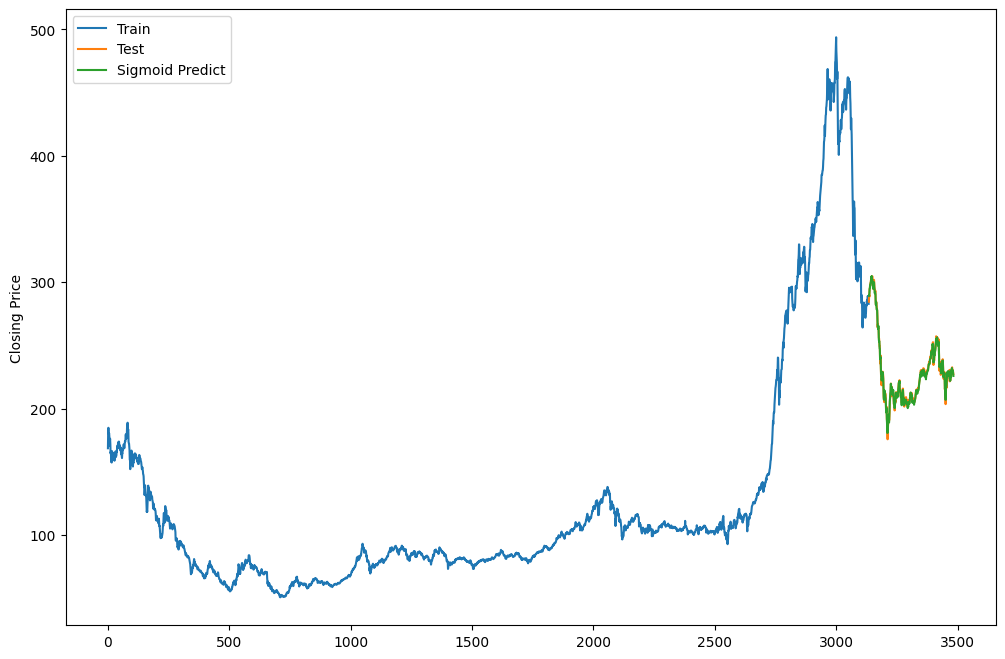

In [52]:
#vẽ mô hình
plt.figure(figsize=(12, 8))
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(X_test.index, y_pred_sigmoid, label='Sigmoid Predict')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [53]:
# láy giá trị Close của ngày cuối cùng trong dataset
last_row = data.tail(1)
last_data = last_row['Open'].values.reshape(-1,1)
last_data

array([[227.2]])

In [54]:
x_next_30_day_sigmoid = []

# predict giá Close 30 ngày tiếp theo dựa vào giá Close của ngày trước đó
for i in range(30):
    x_pred_next = svr_modal.predict(last_data)
    x_next_30_day_sigmoid.append(x_pred_next)
    last_data = x_pred_next.reshape(-1,1)

print(x_next_30_day_sigmoid)

[array([224.53101716]), array([221.84552485]), array([219.14132368]), array([216.41661757]), array([213.67016458]), array([210.90144157]), array([208.1108183]), array([205.29973343]), array([202.47086156]), array([199.62825617]), array([196.77745035]), array([193.92549462]), array([191.08091197]), array([188.25355396]), array([185.45434993]), array([182.69495375]), array([179.98730673]), array([177.34314979]), array([174.77352831]), array([172.28833709]), array([169.89594846]), array([167.60295472]), array([165.41403991]), array([163.33197797]), array([161.3577402]), array([159.49068513]), array([157.72880025]), array([156.06896692]), array([154.50722417]), array([153.03901412])]


In [55]:
predicted_date = create_weekdays_december_january_dataframe()
# predicted_date['Date'] = pd.to
future_30_days_df = pd.DataFrame()
future_30_days_df["Open sigmoid"] = pd.DataFrame(np.concatenate(x_next_30_day_sigmoid), index=predicted_date["Date"], columns=["Open sigmoid"])

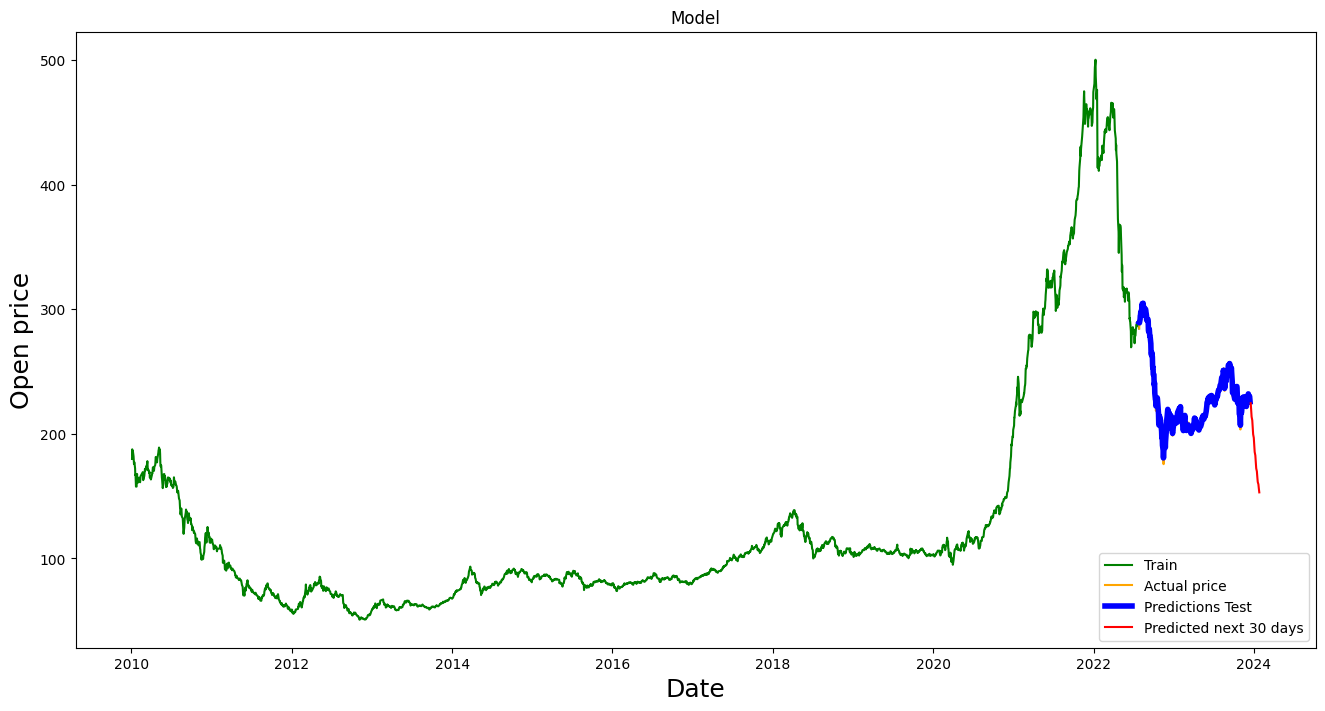

In [56]:
predicted_date = create_weekdays_december_january_dataframe()
future_30_days_df = pd.DataFrame(x_next_30_day_sigmoid, index=predicted_date["Date"], columns=["Open"])
future_30_days_df.index = pd.to_datetime(future_30_days_df.index)

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open price', fontsize=18)
plt.plot(train_data["Date"], X_train, color='green')
plt.plot(test_data["Date"], test_data["Open"], color='orange')
plt.plot(test_data["Date"],y_pred_sigmoid, color='blue', lw=4)
plt.plot(future_30_days_df.index, future_30_days_df['Open'], label='Predicted next 30 days', color = 'red')
plt.legend(['Train','Actual price', 'Predictions Test', 'Predicted next 30 days'], loc='lower right')
plt.show()